In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tweepy as tw

In [17]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_token_secret = ''

In [18]:
# Authenticate
auth = tw.OAuthHandler(consumer_key, consumer_secret)
# Set Tokens
auth.set_access_token(access_token, access_token_secret)
# Instantiate API
api = tw.API(auth, wait_on_rate_limit=True)

In [19]:
tweets = api.user_timeline(screen_name = "tesla", count = 1000, tweet_mode = "extended")

In [21]:
df = pd.DataFrame([tweet.full_text for tweet in tweets], columns = ["tweet"])
df.head()

,tweet
0,Safety will continue to improve via over-the-a...
1,Giga Berlin-Brandenburg County Fair https://t....
2,RT @elonmusk: Please consider joining Tesla AI...
3,Tesla Shareholder Meeting https://t.co/uEv7dE43dC
4,NYC as seen through Model Y glass roof\n\n📸: @...


In [23]:
# Import stopwords
import nltk
from nltk.corpus import stopwords

# Import textblob
from textblob import Word, TextBlob

In [35]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = stopwords.words('english')
custom_stopwords = ['#tesla','#elonmusk','#ev','@tesla','@elonmusk','elonmusk','tesla','ev','RT']

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gajay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\gajay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [36]:
import re
emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags=re.UNICODE)
def preprocess_tweets(tweet, custom_stopwords):
    processed_tweet = tweet
    processed_tweet = emoji_pattern.sub(r'',processed_tweet)
    processed_tweet = re.sub(r"@[A-Za-z0-9]+", "", processed_tweet)
    processed_tweet = re.sub(r"#", "", processed_tweet)
    processed_tweet = re.sub(r"RT[\s]+", "", processed_tweet)
    processed_tweet = re.sub(r"https?:\/\/\S+", "", processed_tweet)
    processed_tweet = processed_tweet.replace('[^\w\s]', '')
    processed_tweet = " ".join(word for word in processed_tweet.split() if word not in stop_words)
    processed_tweet = " ".join(word for word in processed_tweet.split() if word not in custom_stopwords)
    processed_tweet = " ".join(Word(word).lemmatize() for word in processed_tweet.split())
    return(processed_tweet)

df['Processed Tweet'] = df['tweet'].apply(lambda x: preprocess_tweets(x, custom_stopwords))
df.head()

,tweet,Processed Tweet
0,Safety will continue to improve via over-the-a...,Safety continue improve via over-the-air update
1,Giga Berlin-Brandenburg County Fair https://t....,Giga Berlin-Brandenburg County Fair
2,RT @elonmusk: Please consider joining Tesla AI...,: Please consider joining Tesla AI software ha...
3,Tesla Shareholder Meeting https://t.co/uEv7dE43dC,Tesla Shareholder Meeting
4,NYC as seen through Model Y glass roof\n\n📸: @...,NYC seen Model Y glass roof : _City_


In [38]:
print('Base review\n', df['tweet'][0])
print('\n------------------------------------\n')
print('Cleaned and lemmatized review\n', df['Processed Tweet'][0])

Base review
 Safety will continue to improve via over-the-air updates https://t.co/HvXQEboAUs

------------------------------------

Cleaned and lemmatized review
 Safety continue improve via over-the-air update


In [39]:
# Calculate polarity
df['polarity'] = df['Processed Tweet'].apply(lambda x: TextBlob(x).sentiment[0])
df['subjectivity'] = df['Processed Tweet'].apply(lambda x: TextBlob(x).sentiment[1])

In [43]:
df

,tweet,Processed Tweet,polarity,subjectivity
0,Safety will continue to improve via over-the-a...,Safety continue improve via over-the-air update,0.0,0.0
1,Giga Berlin-Brandenburg County Fair https://t....,Giga Berlin-Brandenburg County Fair,0.7,0.9
2,RT @elonmusk: Please consider joining Tesla AI...,: Please consider joining Tesla AI software ha...,0.0,0.0
3,Tesla Shareholder Meeting https://t.co/uEv7dE43dC,Tesla Shareholder Meeting,0.0,0.0
4,NYC as seen through Model Y glass roof\n\n📸: @...,NYC seen Model Y glass roof : _City_,0.0,0.0
...,...,...,...,...
195,Data from our track tests indicates that Model...,Data track test indicates Model S Plaid achiev...,0.0,0.5
196,Model 3 has earned the IIHS 2019 Top Safety Pi...,Model 3 earned IIHS 2019 Top Safety Pick+ Awar...,0.5,0.5
197,@FredericLambert nope,nope,0.0,0.0
198,@DMC_Ryan 💪🔋,_Ryan,0.0,0.0


In [45]:
display(df[['polarity','subjectivity']].agg([np.mean, np.max, np.min, np.median]))

,polarity,subjectivity
mean,0.102313,0.234262
amax,1.000000,1.000000
amin,-1.000000,0.000000
median,0.000000,0.000000


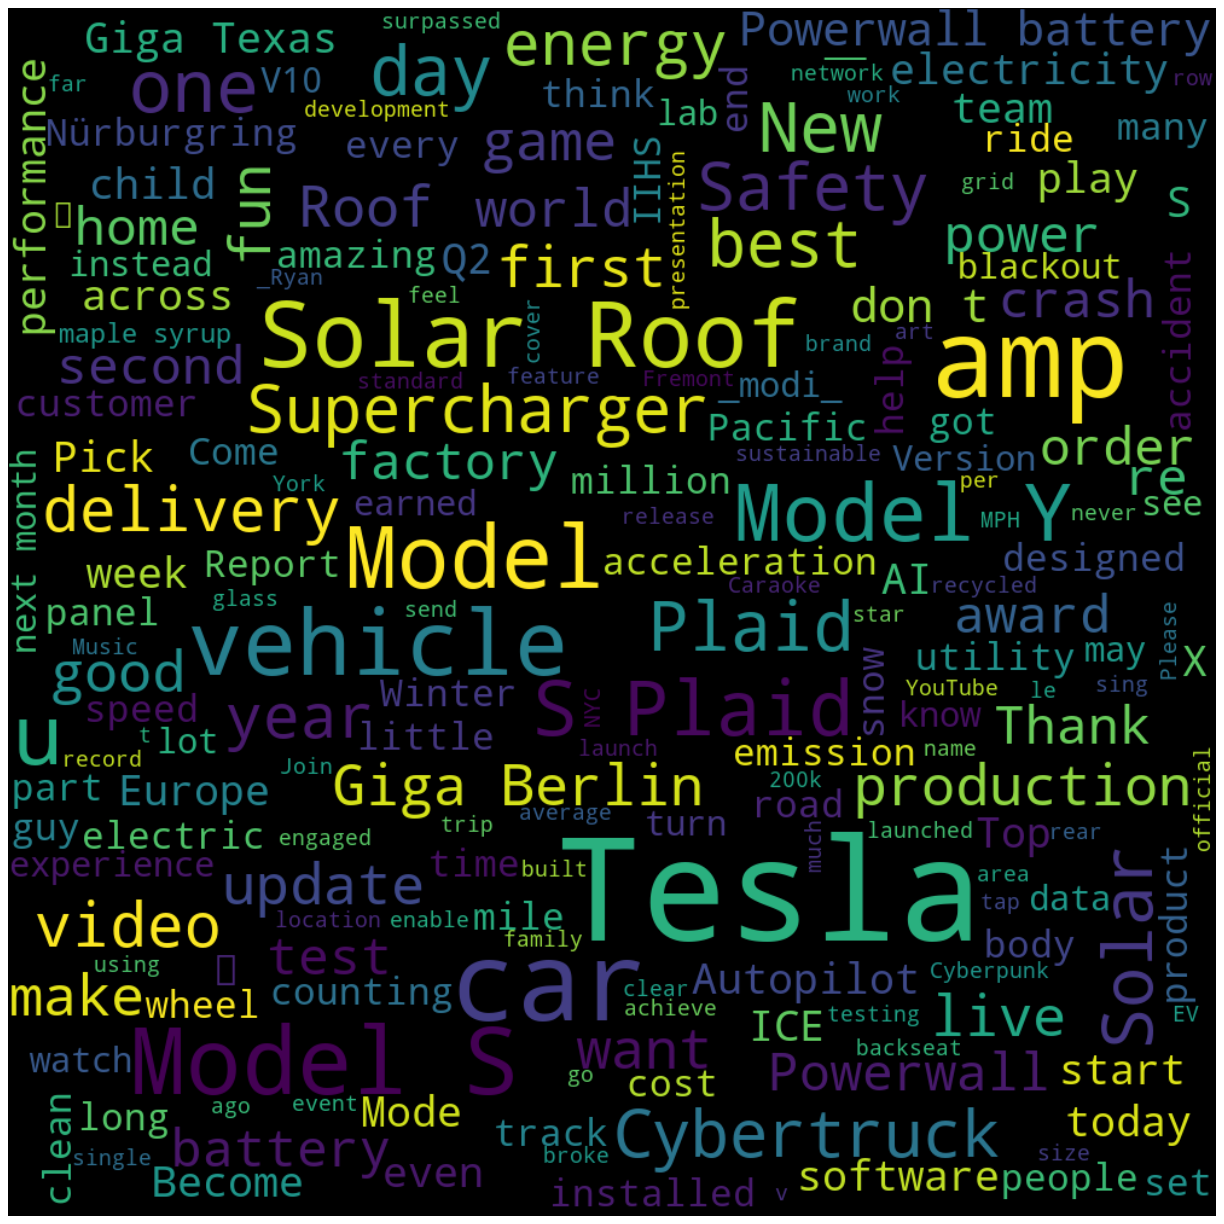

In [51]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

allwords = " ".join([twts for twts in df["Processed Tweet"]])
wordCloud = WordCloud(width = 1000, height = 1000, random_state = 21, max_font_size = 119).generate(allwords)
plt.figure(figsize=(20, 20), dpi=80)
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [52]:
# Compute The Negative, Neutral, Positive Analysis
def analysis(score):
    if score < 0:
        return "Negative"
    elif score == 0:
        return "Neutral"
    else:
        return "Positive"
    
# Create a New Analysis Column
df["analysis"] = df["polarity"].apply(analysis)
# Print The Data
df

,tweet,Processed Tweet,polarity,subjectivity,analysis
0,Safety will continue to improve via over-the-a...,Safety continue improve via over-the-air update,0.0,0.0,Neutral
1,Giga Berlin-Brandenburg County Fair https://t....,Giga Berlin-Brandenburg County Fair,0.7,0.9,Positive
2,RT @elonmusk: Please consider joining Tesla AI...,: Please consider joining Tesla AI software ha...,0.0,0.0,Neutral
3,Tesla Shareholder Meeting https://t.co/uEv7dE43dC,Tesla Shareholder Meeting,0.0,0.0,Neutral
4,NYC as seen through Model Y glass roof\n\n📸: @...,NYC seen Model Y glass roof : _City_,0.0,0.0,Neutral
...,...,...,...,...,...
195,Data from our track tests indicates that Model...,Data track test indicates Model S Plaid achiev...,0.0,0.5,Neutral
196,Model 3 has earned the IIHS 2019 Top Safety Pi...,Model 3 earned IIHS 2019 Top Safety Pick+ Awar...,0.5,0.5,Positive
197,@FredericLambert nope,nope,0.0,0.0,Neutral
198,@DMC_Ryan 💪🔋,_Ryan,0.0,0.0,Neutral


In [59]:
positive_tweets = df[df['analysis'] == 'Positive']
negative_tweets = df[df['analysis'] == 'Negative']

print('positive tweets')
for i, row in positive_tweets[:10].iterrows():
  print(' -' + row['tweet'])

print('negative tweets')
for i, row in negative_tweets[:10].iterrows():
  print(' -' + row['tweet'])

positive tweets
 -Giga Berlin-Brandenburg County Fair https://t.co/s25GaYuujl
 -RT @elonmusk: With https://t.co/45B5nUBaxb &amp; Powerwall battery you are your own utility. 

24/7 clean, sustainable electricity.
 -Solar Roof generating clean energy in Aspen, CO 🏔

📸 @weddleandsons https://t.co/5Ar8ndjoXF
 -RT @elonmusk: Tesla Model S Plaid just set official world speed record for a production electric car at Nurburgring. Completely unmodified,…
 -@AustinTeslaClub @gailalfa1 @elonmusk @IheartTesla @Model3Owners @anuarbekiman @TeslaForThe_Win @TeslaNY @JohnEG78 @MichaelDanberry Solar Roof comes in all shapes &amp; sizes
 -Tesla AI Day presentation streaming live from https://t.co/shRnZSwgd4 at 5pm Pacific today
 -RT @elonmusk: Giga Berlin-Brandenburg county fair &amp; factory tour on 9 October!
 -In 2020, a Tesla with Autopilot engaged experienced 0.2 accidents per million miles driven, while the US average was 9x higher https://t.co/4Zu5sMLyeQ
 -Our vehicles emit much less CO2 than ICE 